In [11]:
import importlib
import arbol
importlib.reload(arbol)
from arbol import *
import numpy as np

In [35]:
nroot = GPTree('add', 
    left=GPTree('mul',
        left=GPTree(3),
        right=GPTree('x')), 
    right=GPTree('inv', 
        left=GPTree(0.5)))
nroot2 = GPTree('mul',
        left=GPTree(3),
        right=GPTree('x')) 
    

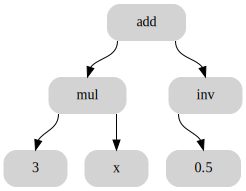

In [122]:
nroot.graphviz()

In [21]:
def target_func(x): # evolution's target
    return x*x*x*x + x*x*x + x*x + x + 1

def generate_dataset(): # generate 101 data points from target_func
    dataset = []
    for x in range(-100,101,2): 
        x /= 100
        dataset.append([x, target_func(x)])
    return dataset

dataset = np.array(generate_dataset())

In [38]:
nroot.size

6

In [32]:
def mae(y, y_pred, w=None):
    return np.average(np.abs(y-y_pred), weights=w)

def mse(y, y_pred, w=None):
    return np.average(np.power(y-y_pred,2), weights=w)

def rmse(y, y_pred, w=None):
    return np.sqrt(mse(y, y_pred, w=w))

In [40]:
ERROR_FUNC = rmse
FIT_ADJUST_SIZE = 0
def eval_fitness(tree, x, y, w=None):
    y_pred = tree.calculate_recursive(x)
    return ERROR_FUNC(y,y_pred,w=w)*(1+FIT_ADJUST_SIZE*tree.size)

eval_fitness(nroot, dataset[:,0], dataset[:,1])

1.102060361907844

In [43]:
trees = [nroot, nroot2]
np.array([eval_fitness(tree, dataset[:,0], dataset[:,1]) for tree in trees])

array([1.10206036, 1.84573786])

In [33]:
x = np.array([11., 0., 2.4])
print(nroot.calculate_recursive(x), nroot.calculate_stack(x))

[35.   2.   9.2] [35.   2.   9.2]
